In [32]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [33]:
# load env variables from .env file
import dotenv
dotenv.load_dotenv()

True

In [47]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(
        openai_api_base="https://openrouter.ai/api/v1",
        model="google/gemini-2.0-flash-001"
    )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [5]:
graph = graph_builder.compile()

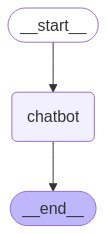

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm **DeepSeek Chat**, an AI assistant created by **DeepSeek**, and here’s what I can do for you:  

### 🔍 **Knowledge & Assistance**  
- Answer questions on diverse topics (science, history, tech, entertainment, etc.).  
- Provide explanations, summaries, and detailed analyses.  
- Offer step-by-step problem-solving for math, coding, and logic puzzles.  

### 📄 **Document Processing**  
- Read and analyze uploaded documents (**PDFs, Word, Excel, PowerPoint, TXT**).  
- Extract key information, summarize content, or answer questions about the document.  

### 📝 **Writing & Editing**  
- Help with essays, reports, emails, and creative writing (stories, poems, scripts).  
- Rewrite, proofread, or refine your text for clarity and style.  

### 💻 **Coding & Tech Support**  
- Write, debug, and optimize code in Python, Java, C++, JavaScript, and more.  
- Explain programming concepts, algorithms, and best practices.  

### 🌍 **Translation & Language Skills**  
- Translate between

In [56]:
from langchain_core.tools import tool
from enum import Enum
from langchain_core.messages import HumanMessage, SystemMessage

class LocationEnum(str, Enum):
    kitchen = "kitchen"
    living_room = "living_room"
    bedroom = "bedroom"

@tool
def go_to_coordinates(x: float, y: float):
    """
    Move the robot to a specific set of coordinates.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If x or y is not a number.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'success', 'message': 'Moved to coordinates (10.5, 20.3)'}
    Example:
        >>> go_to_coordinates("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move to coordinates (10.5, 20.3)'}
    """
    print(f"Moving to coordinates ({x}, {y})")
    # Here you would add the code to move the robot to the specified coordinates
    return {"status": "success", "message": f"Moved to coordinates ({x}, {y})"}

@tool
def go_to_location(location_name: LocationEnum):
    """
    Move the robot to a specific location.
    Args:
        location_name (LocationEnum): The name of the location.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If location_name is not a valid location.
    Example:
        >>> go_to_location("kitchen")
        {'status': 'success', 'message': 'Moved to location: kitchen'}
    Example:
        >>> go_to_location("garage")
        ValueError: location_name must be one of ['kitchen', 'living_room', 'bedroom'].
    Example:
        >>> go_to_location("living_room")
        {'status': 'failure', 'message': 'Failed to move to location: living_room'}
    """
    print(f"Moving to location: {location_name}")
    # Here you would add the code to move the robot to the specified location
    return {"status": "success", "message": f"Moved to location: {location_name}"}

@tool
def rotate(angle: float):
    """
    Rotate the robot to a specific angle.
    Args:
        angle (float): The angle to rotate to.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If angle is not a number.
    Example:
        >>> rotate(90)
        {'status': 'success', 'message': 'Rotated to angle: 90'}
    Example:
        >>> rotate("90")
        ValueError: angle must be a number.
    Example:
        >>> rotate(90)
        {'status': 'failure', 'message': 'Failed to rotate to angle: 90'}
    """
    print(f"Rotating to angle: {angle}")
    # Here you would add the code to rotate the robot to the specified angle
    return {"status": "success", "message": f"Rotated to angle: {angle}"}

llm_with_tools = llm.bind_tools(
    tools=[
        go_to_coordinates,
        go_to_location,
        rotate
    ]
)

In [60]:
from langgraph.graph import MessagesState
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
def navigation_agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

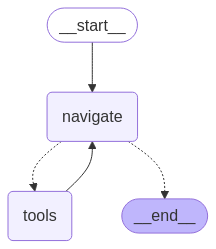

In [61]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Add nodes
builder.add_node("navigate", navigation_agent)
builder.add_node("tools", ToolNode([go_to_coordinates, go_to_location, rotate]))

# Add edges
builder.add_edge(START, "navigate")
builder.add_conditional_edges(
    "navigate",
    tools_condition
)
builder.add_edge("tools", "navigate")

react_graph = builder.compile()
try:
    display(Image(react_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [62]:
messages = [HumanMessage(content="Can you help me navigate to the kitchen?")]
messages = react_graph.invoke({"messages": messages})

for m in messages["messages"]:
    print(m.content)

Moving to location: kitchen
Can you help me navigate to the kitchen?

{"status": "success", "message": "Moved to location: kitchen"}
OK. I have moved to the kitchen.

